In [24]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l273i7q7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l273i7q7
  Resolved https://github.com/albumentations-team/albumentations to commit 30deec1ee4f3bf8e56c43baa894de970e609852b
  Preparing metadata (setup.py) ... done


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)


torch.cuda.is_available()

True

In [26]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [27]:
X = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*'))

In [28]:
len(y)

2841

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [30]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

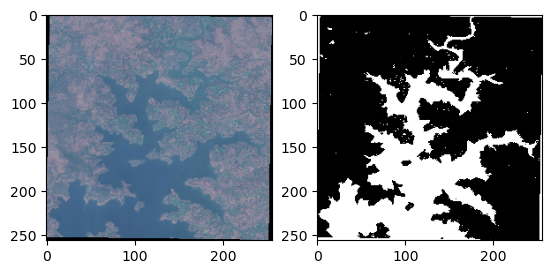

In [31]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [32]:
DEVICE='cuda'

EPOCHS=45
BATCH_SIZE=32
LR=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=18

ENCODER='resnet50'
WEIGHTS='imagenet'

In [33]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [34]:
!pip install segmentation-models-pytorch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [1]:
import torch
import torch.nn as nn
import pickle
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


    def save(self, filepath="./model.pkl"):
        """
        Saves the Network model in the given filepath.
        Parameters
        ----------
        filepath: filepath of the model to be saved
        Returns
        -------
        None
        """
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)

    def load(self, filepath="./model.pkl"):
        """
        Loads a pre-trained Network model from the given filepath.
        Parameters
        ----------
        filepath: filepath of the model to be loaded
        Returns
        -------
        model: Loaded Network model
        """
        with open(filepath, 'rb') as f:
            return pickle.load(f)

In [36]:
# #GPT U-net
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     def __init__(self, in_channels, n_classes):
#         super(UNet, self).__init__()

#         def conv_block(in_dim, out_dim):
#             return nn.Sequential(
#                 nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
#                 nn.ReLU(inplace=True)
#             )

#         def up_conv(in_dim, out_dim):
#             return nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2)

#         # Contracting Path (downsampling)
#         self.conv1 = conv_block(in_channels, 64)
#         self.conv2 = conv_block(64, 128)
#         self.conv3 = conv_block(128, 256)
#         self.conv4 = conv_block(256, 512)

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Expanding Path (upsampling)
#         self.up_conv3 = up_conv(512, 256)
#         self.up_conv2 = up_conv(256, 128)
#         self.up_conv1 = up_conv(128, 64)

#         self.conv3m = conv_block(512, 256)
#         self.conv2m = conv_block(256, 128)
#         self.conv1m = conv_block(128, 64)

#         # Output layer
#         self.conv0m = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         # Downsampling
#         conv1 = self.conv1(x)
#         x = self.pool(conv1)
#         conv2 = self.conv2(x)
#         x = self.pool(conv2)
#         conv3 = self.conv3(x)
#         x = self.pool(conv3)
#         conv4 = self.conv4(x)

#         # Upsampling
#         x = self.up_conv3(conv4)
#         x = torch.cat([x, conv3], dim=1)
#         x = self.conv3m(x)
#         x = self.up_conv2(x)
#         x = torch.cat([x, conv2], dim=1)
#         x = self.conv2m(x)
#         x = self.up_conv1(x)
#         x = torch.cat([x, conv1], dim=1)
#         x = self.conv1m(x)
#         x = self.conv0m(x)

#         return x

In [2]:
!pip install segmentation-models-pytorch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=eec350523a9aea73fc4d6002561300f22f4d0639cf66e7b8b989961157374569
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=1fee4ddc1675ecfbfe4be017c61c899a2acedd71b0043a60459bd8cfdfa97b8e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

#         self.arc=smp.Unet(
#             encoder_name=ENCODER,
#             encoder_weights=WEIGHTS,
#             in_channels=3,
#             classes=1,
#             activation=None
#         )
    
        self.arc = UNet(3, 1)
    
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [6]:
DEVICE='cuda'
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128

In [11]:
# !pip install torchsummary
# model.summary
# summary(model, (1,256,256))
print(model)

SegmentationModel(
  (arc): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128

In [40]:
def iou(pred_mask, true_mask, n_classes=2):
    ious = []
#     pred= torch.argmax(pred, dim =1)
    pred = pred_mask.view(-1)
    target = true_mask.view(-1)

    # Ignore IoU for undefined class ("9")
    for cls in range(n_classes-1):  # last class is ignored

        pred_inds = pred == cls
        target_inds = target == cls
        intersection = torch.sum(pred_inds & target_inds)
        union = torch.sum(pred_inds | target_inds)
        if float(union) == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection / union))


    return torch.mean(torch.Tensor(ious)).item()

In [41]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    total_loss = 0.0
    total_iou = 0.0
    count =0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)
        
        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        
        
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        
        pred_mask=torch.sigmoid(logits)
        pred_mask=(pred_mask > ratio)*1.0
        total_iou += iou(pred_mask, masks)
        count+=1
    print("IoU train,", total_iou/count)
    
#         intersection = torch.logical_and(logits, masks).sum()
#         union = torch.logical_or(logits, masks).sum()
#         iou = intersection.float() / union.float()
#         print("iou train:",iou)
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [42]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    total_iou=0
    count = 0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
            pred_mask=torch.sigmoid(logits)
            pred_mask=(pred_mask > ratio)*1.0
            total_iou += iou(pred_mask, masks)
            count+=1
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
    
    print("IoU val,", total_iou/count)
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [43]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
print("device", DEVICE)
#torch.optim.Adam(model.parameters(),lr=LR)

device cuda


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.6216681960970163


100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


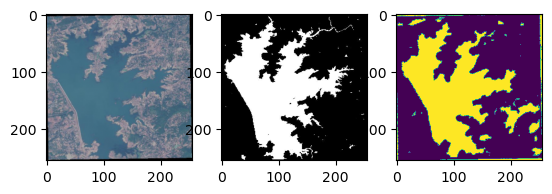

IoU val, 0.6743292146258884
Epochs:1
Train_loss --> Dice: 0.48069497272372247 BCE: 0.5381307374686003 
Valid_loss --> Dice: 0.4270397358470493 BCE: 0.46237971054183113
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.6718945890665055


100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


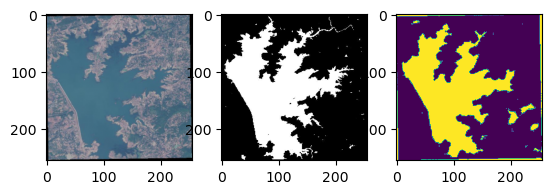

IoU val, 0.6867424183421664
Epochs:2
Train_loss --> Dice: 0.4100649982690811 BCE: 0.4667257759720087 
Valid_loss --> Dice: 0.37750374608569676 BCE: 0.4573455784055922
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.6964606396853924


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


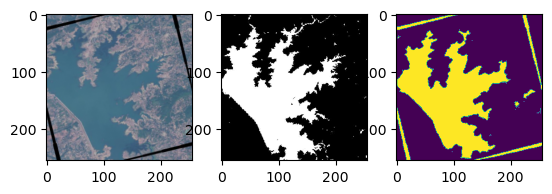

IoU val, 0.7060233884387546
Epochs:3
Train_loss --> Dice: 0.3764523953199387 BCE: 0.442243817076087 
Valid_loss --> Dice: 0.36387132273779976 BCE: 0.44287459386719596
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7150682084262371


100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


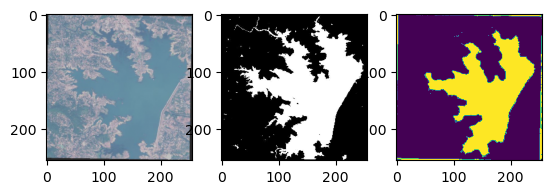

IoU val, 0.6852852172321744
Epochs:4
Train_loss --> Dice: 0.35343477576971055 BCE: 0.42019825652241705 
Valid_loss --> Dice: 0.3696706361240811 BCE: 0.48128143284055924


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7259449377655983


100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


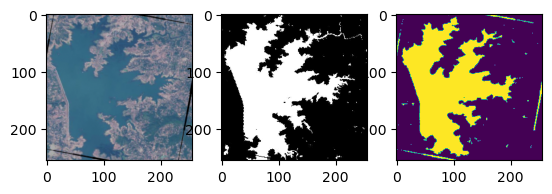

IoU val, 0.730444934633043
Epochs:5
Train_loss --> Dice: 0.334483053535223 BCE: 0.4084651652723551 
Valid_loss --> Dice: 0.3359810445043776 BCE: 0.41627224286397296
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7340437918901443


100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


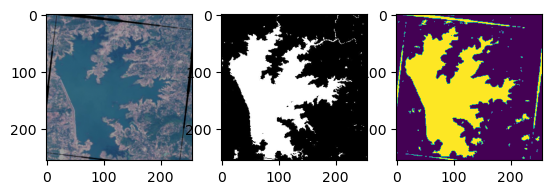

IoU val, 0.7525934179623922
Epochs:6
Train_loss --> Dice: 0.3221057504415512 BCE: 0.3948270991444588 
Valid_loss --> Dice: 0.3346985975901286 BCE: 0.3623209032747481
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7372638195753097


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


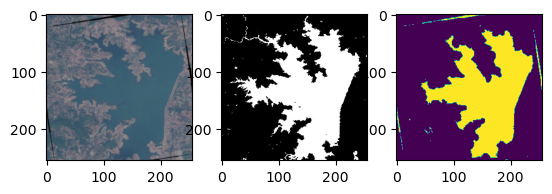

IoU val, 0.7453961902194552
Epochs:7
Train_loss --> Dice: 0.31661844104528425 BCE: 0.3913745809346437 
Valid_loss --> Dice: 0.33348096079296535 BCE: 0.3859029842747582
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7420500248670578


100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


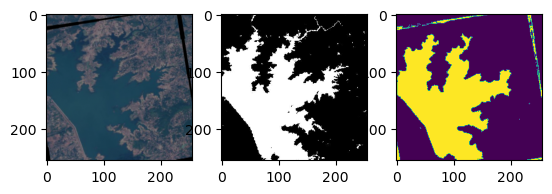

IoU val, 0.7640353043874105
Epochs:8
Train_loss --> Dice: 0.30894229337573054 BCE: 0.38179351687431334 
Valid_loss --> Dice: 0.3060862024625142 BCE: 0.3485892911752065
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7500539541244506


100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


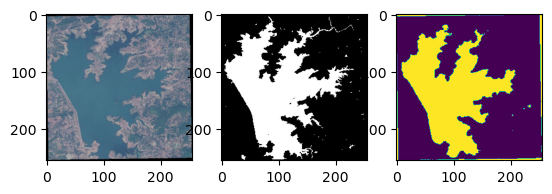

IoU val, 0.7653018633524576
Epochs:9
Train_loss --> Dice: 0.29590936228632925 BCE: 0.3684312142431736 
Valid_loss --> Dice: 0.2934017976125081 BCE: 0.3472141656610701
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.753727862983942


100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


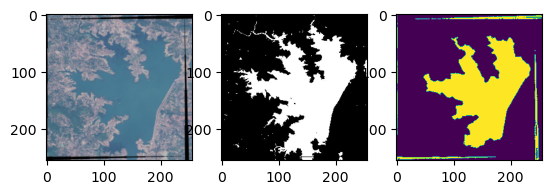

IoU val, 0.7754451168908013
Epochs:10
Train_loss --> Dice: 0.28794698864221574 BCE: 0.3629550490528345 
Valid_loss --> Dice: 0.28233810928132796 BCE: 0.33673672874768573
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7577337242662907


100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


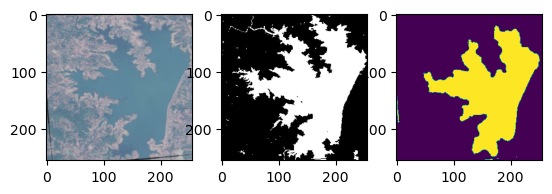

IoU val, 0.7702758577134874
Epochs:11
Train_loss --> Dice: 0.2800549864768982 BCE: 0.35209752172231673 
Valid_loss --> Dice: 0.30774279435475665 BCE: 0.34416184160444474


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7626924358308316


100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


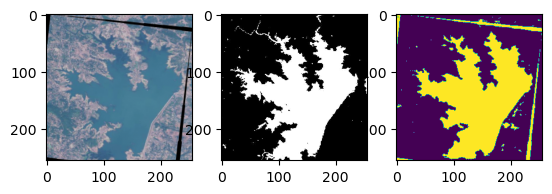

IoU val, 0.7751927971839905
Epochs:12
Train_loss --> Dice: 0.2709825739264488 BCE: 0.344719154573977 
Valid_loss --> Dice: 0.2790256010161506 BCE: 0.32250117096636033
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7658173002302646


100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


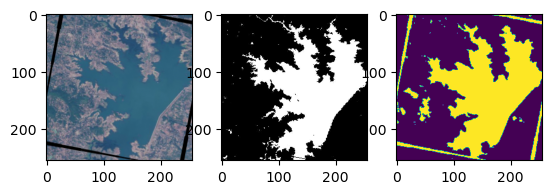

IoU val, 0.7615052858988444
Epochs:13
Train_loss --> Dice: 0.26530991345643995 BCE: 0.3385614423081279 
Valid_loss --> Dice: 0.28360604577594334 BCE: 0.3613378372457292


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7664087787270546


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


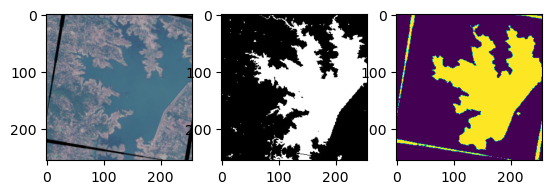

IoU val, 0.7853446669048734
Epochs:14
Train_loss --> Dice: 0.26325046047568323 BCE: 0.3399621004238725 
Valid_loss --> Dice: 0.26580631070666844 BCE: 0.3134365446037716
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7707187995314598


100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


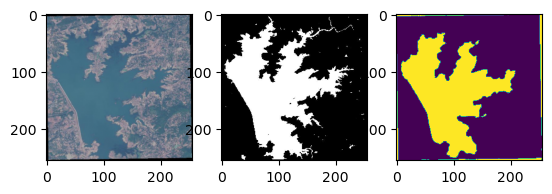

IoU val, 0.786227199766371
Epochs:15
Train_loss --> Dice: 0.2569482378661633 BCE: 0.33035586271435025 
Valid_loss --> Dice: 0.2584241032600403 BCE: 0.3080439352326923
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7733586087822915


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


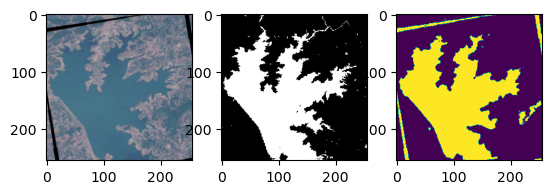

IoU val, 0.7933311131265428
Epochs:16
Train_loss --> Dice: 0.2520145110785961 BCE: 0.32155712191015484 
Valid_loss --> Dice: 0.24058721462885538 BCE: 0.2934565775924259
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7774719335138798


100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


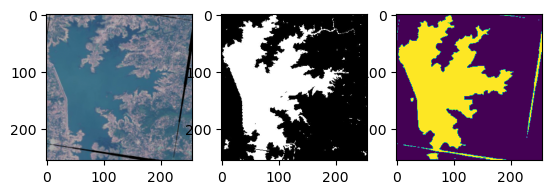

IoU val, 0.794778048992157
Epochs:17
Train_loss --> Dice: 0.24682450518012047 BCE: 0.31702782921493056 
Valid_loss --> Dice: 0.24298086431291369 BCE: 0.29058818022410077
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7788501814007759


100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


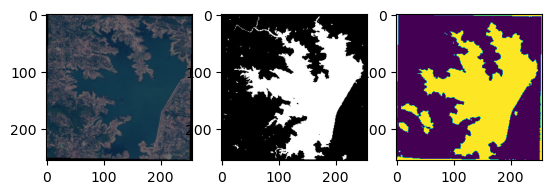

IoU val, 0.782888736989763
Epochs:18
Train_loss --> Dice: 0.2428678795695305 BCE: 0.31722040213644503 
Valid_loss --> Dice: 0.2453392744064331 BCE: 0.3204965756999122


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7793175645172596


100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


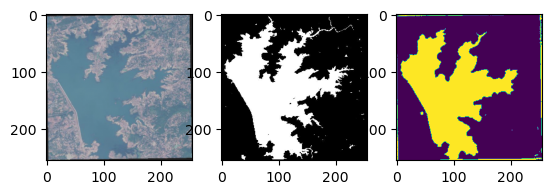

IoU val, 0.796173632144928
Epochs:19
Train_loss --> Dice: 0.23942273929715158 BCE: 0.3132913978770375 
Valid_loss --> Dice: 0.23923952049679226 BCE: 0.2874968432717853
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7846910074353218


100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


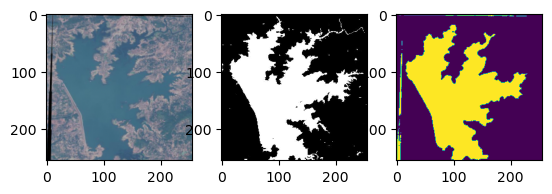

IoU val, 0.7927392390039232
Epochs:20
Train_loss --> Dice: 0.2320591241121292 BCE: 0.3016039377078414 
Valid_loss --> Dice: 0.24639119704564413 BCE: 0.2924342105786006


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7824518196284771


100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


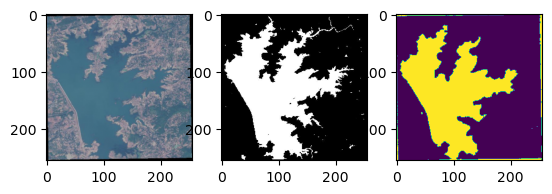

IoU val, 0.7980882326761881
Epochs:21
Train_loss --> Dice: 0.23328642398118973 BCE: 0.3062564043328166 
Valid_loss --> Dice: 0.2300797833336724 BCE: 0.287311433090104
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7842991352081299


100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


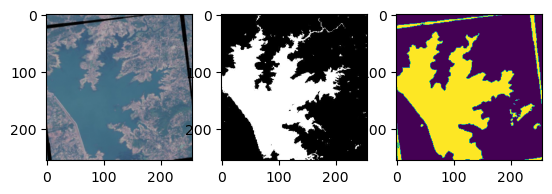

IoU val, 0.7950807876057095
Epochs:22
Train_loss --> Dice: 0.2311519466340542 BCE: 0.30447999350726607 
Valid_loss --> Dice: 0.2374809119436476 BCE: 0.29012155532836914


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7837019219994545


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


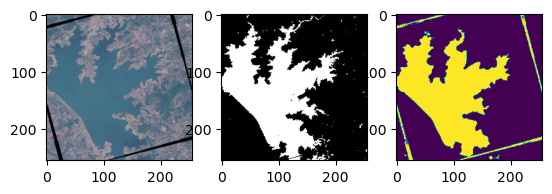

IoU val, 0.798878722720676
Epochs:23
Train_loss --> Dice: 0.2305366538465023 BCE: 0.30608955919742586 
Valid_loss --> Dice: 0.23556973536809286 BCE: 0.27654239038626355
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7871855609118938


100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


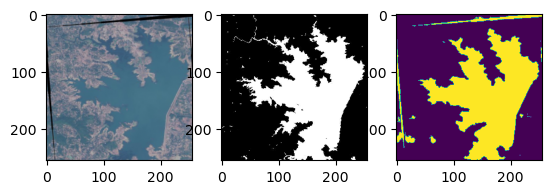

IoU val, 0.7799541552861532
Epochs:24
Train_loss --> Dice: 0.22586009949445723 BCE: 0.29776935689151285 
Valid_loss --> Dice: 0.24644607967800564 BCE: 0.30358919501304626


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7890387810766697


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


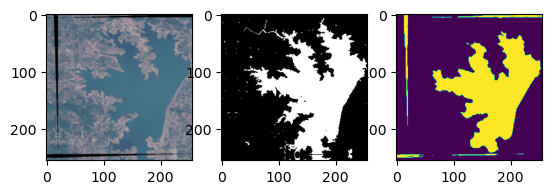

IoU val, 0.7972842190000746
Epochs:25
Train_loss --> Dice: 0.224453254789114 BCE: 0.29361017029732467 
Valid_loss --> Dice: 0.2256285548210144 BCE: 0.2903551657994588
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.789775262773037


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


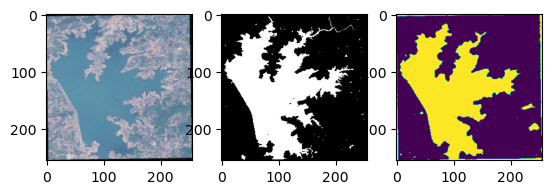

IoU val, 0.7914764218860202
Epochs:26
Train_loss --> Dice: 0.22185874804854394 BCE: 0.29537261500954626 
Valid_loss --> Dice: 0.23347754610909355 BCE: 0.3057231654723485


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7911469772458076


100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


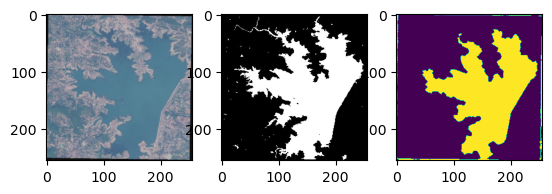

IoU val, 0.7928951912456088
Epochs:27
Train_loss --> Dice: 0.22066843137145042 BCE: 0.2902682423591614 
Valid_loss --> Dice: 0.24179228146870932 BCE: 0.2981542928351296


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7900520130991936


100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


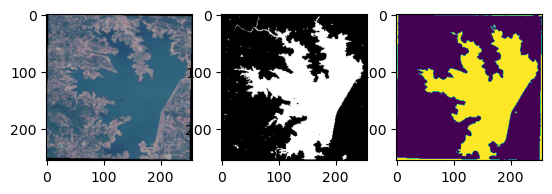

IoU val, 0.8021401961644491
Epochs:28
Train_loss --> Dice: 0.2201449379324913 BCE: 0.29023354724049566 
Valid_loss --> Dice: 0.2265336513519287 BCE: 0.2720832692252265
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.791171170771122


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


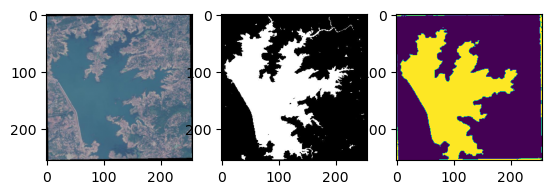

IoU val, 0.8016874657736884
Epochs:29
Train_loss --> Dice: 0.21852572187781333 BCE: 0.2905989244580269 
Valid_loss --> Dice: 0.22451004054811266 BCE: 0.2755935357676612
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7939775459468364


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


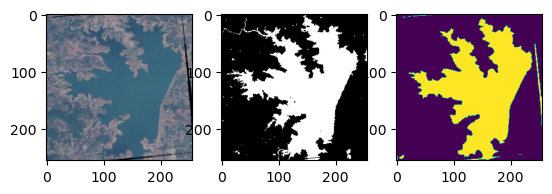

IoU val, 0.8024228281444974
Epochs:30
Train_loss --> Dice: 0.215515898168087 BCE: 0.28354113921523094 
Valid_loss --> Dice: 0.223390261332194 BCE: 0.28003229531976914
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7936494596302509


100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


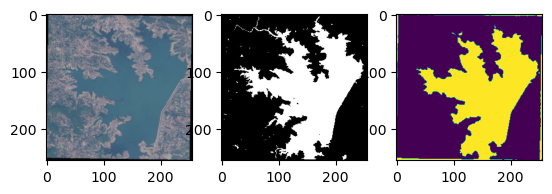

IoU val, 0.8051835497220358
Epochs:31
Train_loss --> Dice: 0.21537947356700898 BCE: 0.28703495878726243 
Valid_loss --> Dice: 0.21707136101192898 BCE: 0.27724676662021214
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7949448391795159


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


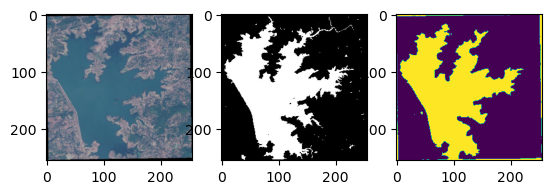

IoU val, 0.8001137773195902
Epochs:32
Train_loss --> Dice: 0.2133677065372467 BCE: 0.2814674612134695 
Valid_loss --> Dice: 0.22626793384552002 BCE: 0.2791726489861806


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7966212399303914


100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


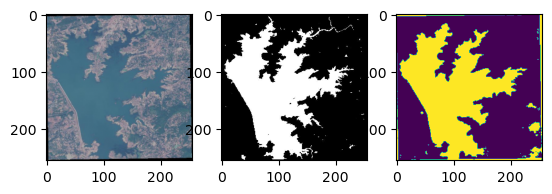

IoU val, 0.779085636138916
Epochs:33
Train_loss --> Dice: 0.21126252338290213 BCE: 0.2798420606181026 
Valid_loss --> Dice: 0.250516414642334 BCE: 0.32338746388753253


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7981531091034413


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


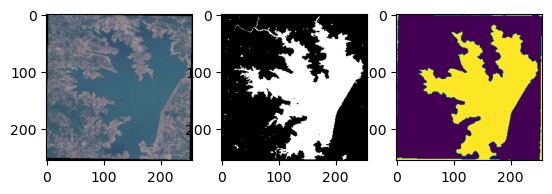

IoU val, 0.8096283475557963
Epochs:34
Train_loss --> Dice: 0.20838028490543364 BCE: 0.2784216973930597 
Valid_loss --> Dice: 0.2143283552593655 BCE: 0.26934608817100525
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.7970826976001263


100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


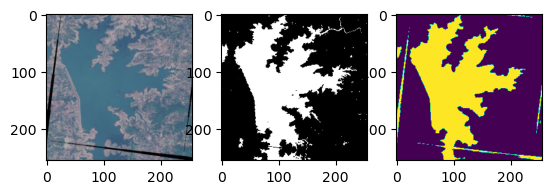

IoU val, 0.8093448215060763
Epochs:35
Train_loss --> Dice: 0.209241147339344 BCE: 0.2803652506321669 
Valid_loss --> Dice: 0.2167030175526937 BCE: 0.26178210642602706
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.7997619211673737


100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


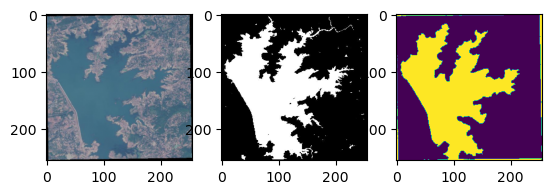

IoU val, 0.8070499764548408
Epochs:36
Train_loss --> Dice: 0.20655886232852935 BCE: 0.27286096196621656 
Valid_loss --> Dice: 0.21241913239161173 BCE: 0.2600203487608168
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.7994523890316486


100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


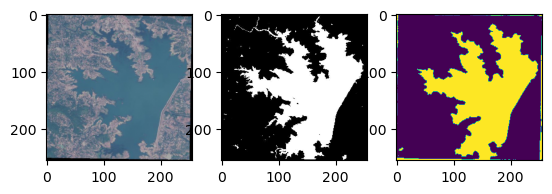

IoU val, 0.806642664803399
Epochs:37
Train_loss --> Dice: 0.20529716610908508 BCE: 0.2729627903550863 
Valid_loss --> Dice: 0.20961730347739327 BCE: 0.2745264735486772
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.799725815653801


100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


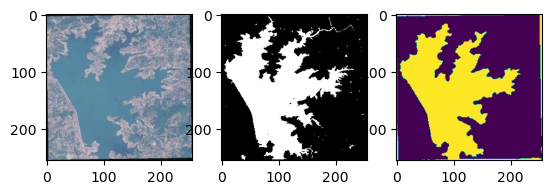

IoU val, 0.810319979985555
Epochs:38
Train_loss --> Dice: 0.20523192510008811 BCE: 0.2752021223306656 
Valid_loss --> Dice: 0.20718231466081408 BCE: 0.265774420566029
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.8007412478327751


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


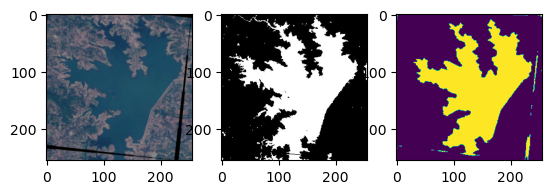

IoU val, 0.8048440549108717
Epochs:39
Train_loss --> Dice: 0.20183183550834655 BCE: 0.2714308112859726 
Valid_loss --> Dice: 0.2274574769867791 BCE: 0.2722479734155867


100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


IoU train, 0.8011739023029805


100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


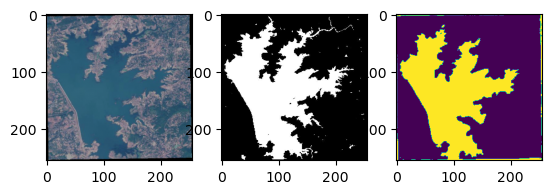

IoU val, 0.797550254397922
Epochs:40
Train_loss --> Dice: 0.20226235091686248 BCE: 0.2694862077012658 
Valid_loss --> Dice: 0.22487592697143555 BCE: 0.2881060408221351


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.8019606344401836


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


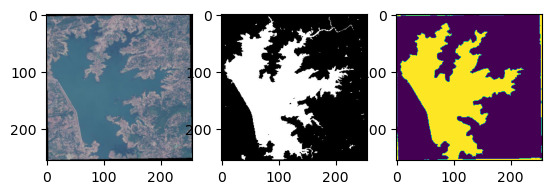

IoU val, 0.808282838927375
Epochs:41
Train_loss --> Dice: 0.20102895125746728 BCE: 0.2711809318512678 
Valid_loss --> Dice: 0.20914278427759805 BCE: 0.25901106827788883
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.803716779500246


100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


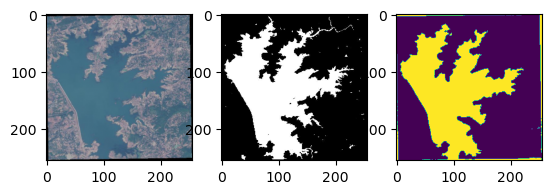

IoU val, 0.8104406860139635
Epochs:42
Train_loss --> Dice: 0.19788388684391975 BCE: 0.26645002476871016 
Valid_loss --> Dice: 0.2156270146369934 BCE: 0.25797851383686066
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.8055046871304512


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


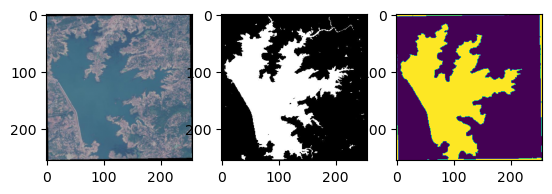

IoU val, 0.8067333963182237
Epochs:43
Train_loss --> Dice: 0.1965053543448448 BCE: 0.26249398235231636 
Valid_loss --> Dice: 0.21317219734191895 BCE: 0.2683144642247094
Model Saved


100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


IoU train, 0.8041828788816929


100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


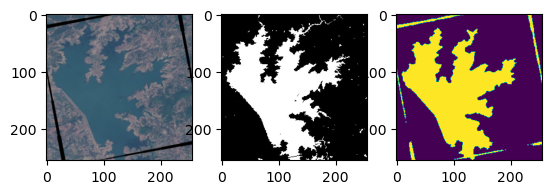

IoU val, 0.8092267248365614
Epochs:44
Train_loss --> Dice: 0.19709404781460763 BCE: 0.2667653687298298 
Valid_loss --> Dice: 0.20377258459726968 BCE: 0.2658340351449119
Model Saved


100%|██████████| 80/80 [01:50<00:00,  1.39s/it]


IoU train, 0.805918812006712


100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


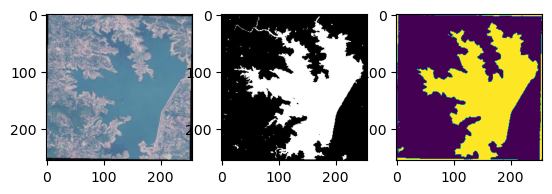

IoU val, 0.8053684963120354
Epochs:45
Train_loss --> Dice: 0.1953417807817459 BCE: 0.26435171309858563 
Valid_loss --> Dice: 0.21869856781429714 BCE: 0.27099300424257916


In [44]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model_custom_Unet.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

In [45]:
num=11
ratio=0.5

model.load_state_dict(torch.load('./best_model.pt'))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))

FileNotFoundError: [Errno 2] No such file or directory: './best_model.pt'

In [ ]:
# import torch
# from PIL import Image
# from torchvision import transforms, models

# # Load the pre-trained model from torchvision
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model.eval()  # Set the model to evaluation mode

# # Define the transform
# transform = transforms.Compose([
#     transforms.Resize((256, 256)), 
#     transforms.ToTensor(),
#     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])

# # Open your image
# image = Image.open('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1.jpg')
# # print("Image shape", image.shape)

# # # Apply the transform to the image
# input_img = transform(image)
# input_img = input_img.unsqueeze(0) # add an extra dimension for the batch
# # input_img = img
# # input_img = input_img.float().unsqueeze(0)  # ensure the input is FloatTensor

# # Check if a GPU is available and if not, run the model on a CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_img = input_img.to(device)
# model = model.to(device)

# # Get the model's prediction
# with torch.no_grad():
#     output = model(input_img)['out'][0]  # we are interested in the output tensor
#     output_predictions = output.argmax(0)  # get the pixel-wise prediction

# # The `output_predictions` now contains the segmentation map for the input image


In [ ]:
# import matplotlib.pyplot as plt

# # Convert the tensor to a numpy array
# output_predictions123 = output_predictions.cpu().numpy()
# # inp = input_img.cpu().numpy()

# # Use matplotlib to display the segmentation map
# plt.imshow(output_predictions123)
# plt.show()

In [ ]:
# Convert the input_img tensor to a numpy array for display
input_img_np = input_img.squeeze().cpu().numpy()
input_img_np = input_img_np.transpose((1, 2, 0))  # transpose dimensions
input_img_np = (input_img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)  # denormalize

# Display the input image
plt.imshow(input_img_np)
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def createDeepLabv3(output_channels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True
    )
    model.classifier = DeepLabHead(2048, output_channels)
    return model

model=createDeepLabv3()
model.to(DEVICE)

In [ ]:
print(model.summary)

In [ ]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    total_loss = 0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
print("device", DEVICE)
#torch.optim.Adam(model.parameters(),lr=LR)

best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf
EPOCHS = 10
for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model_deeplabv3.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce